In [13]:
# Import necessary tools
import pandas as pd
import matplotlib.pyplot as plt
import scipy  as sp
import os

In [14]:
# Set environment variables for bash
WD = os.getcwd()

SRC_DIR = WD + "/.."
BUILD_DIR = WD + "/../../build"
GRAPH_DIR=BUILD_DIR + "/statistics/graphs" # Where we will place the graph plots
RES_IN=BUILD_DIR + "/experiment/res.csv"

%env SRC_DIR=$SRC_DIR
%env BUILD_DIR=$BUILD_DIR
%env GRAPH_DIR=$GRAPH_DIR
%env CSV_DIR=$CSV_DIR
%env RES_IN=$RES_IN

env: SRC_DIR=/home/anthonyd973/Git/swarmlist-list-based/src/statistics/..
env: BUILD_DIR=/home/anthonyd973/Git/swarmlist-list-based/src/statistics/../../build
env: GRAPH_DIR=/home/anthonyd973/Git/swarmlist-list-based/src/statistics/../../build/statistics/graphs
env: CSV_DIR=$CSV_DIR
env: RES_IN=/home/anthonyd973/Git/swarmlist-list-based/src/statistics/../../build/experiment/res.csv


# Data fetching

- Extract bzipped result. **One may put their own results under `<git's root>/build/experiment` instead**, in which case the extracting will be ignored.

In [15]:
%%bash

if [ ! -e "$BUILD_DIR/experiment" ]
then

    ARCHIVE="$SRC_DIR/statistics/results.tbz"
    
    mkdir -p "$BUILD_DIR"
    mkdir -p "$GRAPH_DIR"
    tar -xjf "$ARCHIVE" -C "$BUILD_DIR"
fi

# Data analyzing

- Setup variables

In [16]:
INDEX_NAMES = ["Protocol", "Topology", "Packet drop rate", "Num. robots"]
COLUMN_NAMES=["Consensus time", "Num. tx entries", "Num. rx entries", "Mean tx bandwidth", "Mean rx bandwidth"]
PROTOCOLS=["consensus"] # Our experiments only used the 'consensus' protocol, i.e.,
                        # placing all the robots and waiting for consensus to be reached.
TOPOLOGIES=["line", "cluster", "scalefree"]
DROP_RATES=[0, 0.25, 0.5, 0.75]

- Crunch data

In [17]:
# Gets results' data and renames the axes
def readResults(filename):
    df = pd.read_csv(filename, index_col=[0,1,2,3])
    df.index.names = INDEX_NAMES
    df.columns = COLUMN_NAMES
    return df

In [18]:
# Gives statistical data for each {protocol, topology, drop rate, num robots}
# configuration about the specified column.
def crunchColumnByConfig(df, columnName):
    # Get column's data
    ret = df.xs(columnName, axis=1)
    # Then group experiments by configuration
    ret = ret.groupby(level=[0,1,2,3])
    # Then do some pandas magic stuff
    ret = ret.apply(pd.Series.reset_index, drop=True).unstack().transpose().describe().transpose()
    return ret

In [19]:
data = readResults(RES_IN)
consensusData = crunchColumnByConfig(data, "Consensus time")
consensusData

count         mean  \
Protocol  Topology  Packet drop rate Num. robots                       
consensus cluster   0.00             10            30.0     3.833333   
                                     50            30.0    13.966667   
                                     100           29.0    27.896552   
                                     300           28.0    89.071429   
                                     500           30.0   154.433333   
                                     800           29.0   255.586207   
                                     1000          28.0   322.821429   
                                     2000          28.0   757.571429   
                                     3000          27.0  1147.481481   
                                     5000          27.0  2136.000000   
                    0.25             10            30.0     4.800000   
                                     50            30.0    18.366667   
                                     100           29.0    35.206897   
                                     300           28.0   128.035714   
                                     500           30.0   241.700000   
                                     700           29.0   354.724138   
                                     1000          28.0   498.678571   
                                     2000          28.0  1148.464286   
                    0.50             10            30.0     6.366667   
                                     50            30.0    27.900000   
                                     100           29.0    57.758621   
                                     300           28.0   207.642857   
                                     500           30.0   425.133333   
                                     700           29.0   684.172414   
                                     1000          28.0  1035.035714   
                                     1500          29.0  1770.655172   
                    0.75             10            30.0    11.100000   
                                     50            30.0    59.433333   
                                     100           29.0   141.758621   
                                     200           28.0   299.500000   
...                                                 ...          ...   
          scalefree 0.00             1000          28.0   463.678571   
                                     2000          30.0  1047.666667   
                                     3000          30.0  1747.300000   
                                     5000          29.0  3371.517241   
                    0.25             10            30.0     8.300000   
                                     50            30.0    44.900000   
                                     100           30.0    90.233333   
                                     300           28.0   274.071429   
                                     500           30.0   424.200000   
                                     700           28.0   600.035714   
                                     1000          28.0   857.000000   
                                     2000          30.0  1545.400000   
                                     3000          30.0  2701.500000   
                    0.50             10            30.0    12.800000   
                                     50            30.0    75.633333   
                                     100           30.0   154.000000   
                                     200           30.0   341.333333   
                                     300           28.0   539.000000   
                                     500           30.0   826.833333   
                                     700           28.0  1143.214286   
                                     1000          28.0  1726.464286   
                                     2000          30.0  3317.100000   
                    0.75             10            30.0    25.433333   
                  

# Data displaying

In [20]:
def plotGraph(df, topology, formats, deltas, yscale="linear", xlabel="Number of robots", ylabel="", savefileBaseName=None):
    fig = plt.figure(figsize = (10,5))
    axis = fig.add_subplot(111)
    
    topologyDf = df.xs(topology, level=1)
    plotNumber=0
    for protocol in PROTOCOLS:
        for dropRate in DROP_RATES:
            currDf = topologyDf.xs((protocol, dropRate))

            numsRobots  = currDf.index.tolist()
            numsRobots  = [numsRobots[i] + deltas[plotNumber] for i in range(len(numsRobots))]
            yPlot  = currDf.xs("50%", axis=1)
            yError = [(yPlot - currDf.xs("min", axis=1)),
                      (currDf.xs("max", axis=1) - yPlot)]

            axis.errorbar(numsRobots, yPlot, yerr = yError, fmt=formats[plotNumber] + "-")
            plotNumber += 1

    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.set_yscale(yscale)
    axis.yaxis.grid()
    axis.legend([str(drop*100)+"% drop" for drop in DROP_RATES], loc=0, ncol=1, title=(topology + " topology"))
    
    if savefileBaseName != None:
        plt.savefig(GRAPH_DIR+"/"+savefileBaseName+".png", dpi=600, format="png", transparent=False)

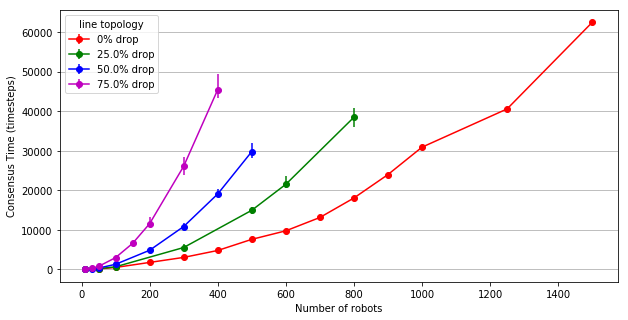

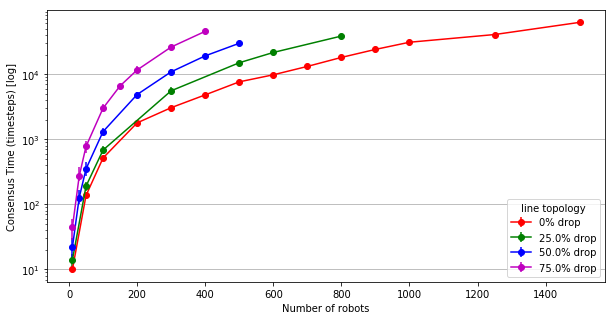

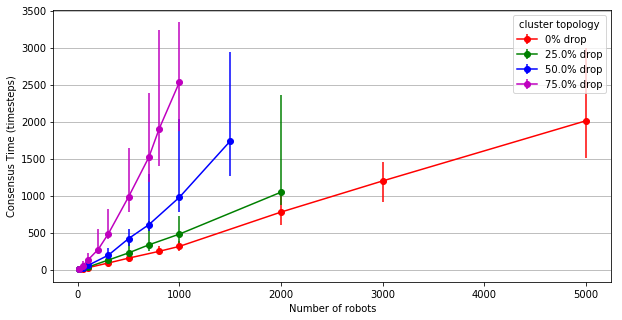

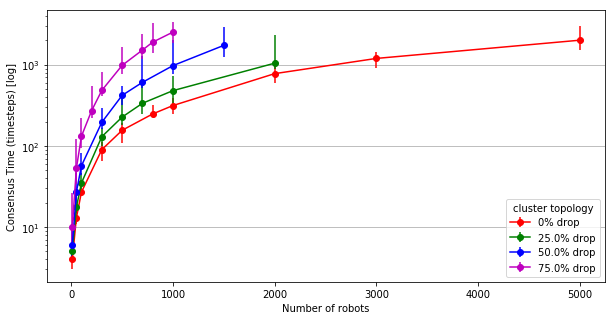

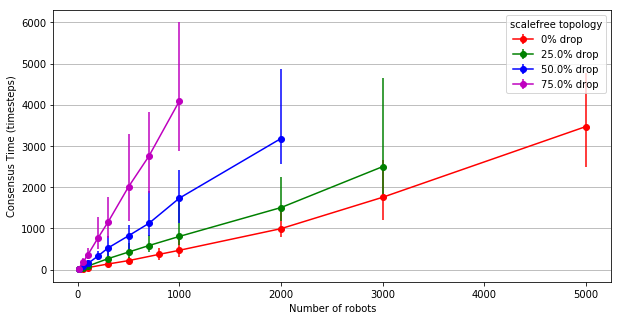

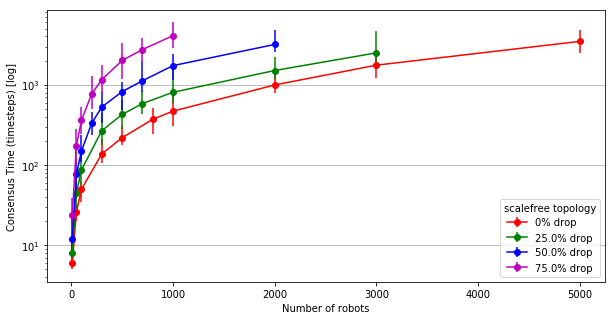

In [21]:
%matplotlib inline

# Set variables
CONSENSUS_YLABEL="Consensus Time (timesteps)"
DELTAS=[0, 0, 0, 0]
FORMATS=["ro", "go", "bo", "mo"]

# Plot graphs
plotGraph(consensusData, "line",      FORMATS, DELTAS, ylabel=CONSENSUS_YLABEL, savefileBaseName="lineConsensus")
plotGraph(consensusData, "line",      FORMATS, DELTAS, yscale="log", ylabel=CONSENSUS_YLABEL + " [log]", savefileBaseName="lineConsensus_log")
plotGraph(consensusData, "cluster",   FORMATS, DELTAS, ylabel=CONSENSUS_YLABEL, savefileBaseName="clusterConsensus")
plotGraph(consensusData, "cluster",   FORMATS, DELTAS, yscale="log", ylabel=CONSENSUS_YLABEL + " [log]", savefileBaseName="clusterConsensus_log")
plotGraph(consensusData, "scalefree", FORMATS, DELTAS, ylabel=CONSENSUS_YLABEL, savefileBaseName="scalefreeConsensus")
plotGraph(consensusData, "scalefree", FORMATS, DELTAS, yscale="log", ylabel=CONSENSUS_YLABEL + " [log]", savefileBaseName="scalefreeConsensus_log")